# Problem Set 2

### Anbar Aizenman, Ilya Lukibanov, Irina Osipova, Isamar Troncoso

## Decision Trees

#### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

##### A

In [2]:
boston = load_boston()
X, y = boston.data, boston.target
n_samples, n_features = X.shape 
print(boston['DESCR']) 

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Information about variables is provided above. Target is the median value of owner-occupied homes in $1000's


##### B

In [3]:
cver = KFold(n_splits=5, shuffle=True, random_state=0)
folds = tuple(cver.split(X, y)) #a tuple of folds (i.e. splits into training and test samples)
# estimation environment object (function):
GridSearch = lambda estimator, estimator_params: GridSearchCV(estimator, estimator_params, cv=folds, scoring='neg_mean_squared_error', return_train_score=True)

In [4]:
tree = DecisionTreeRegressor(random_state=0)
tree_params = {'max_depth': range(1, 9)} #range for max depth of a tree
tree_cv = GridSearch(tree, tree_params) #creates a tree estimator object
tree_cv.fit(X, y) #fits a tree to X,y
tree_cv_results = pd.DataFrame(tree_cv.cv_results_) #estimation results transformed to a pd.dataframe

plt.plot(tree_cv_results['param_max_depth'], -tree_cv_results['mean_test_score'], label='test error')
plt.plot(tree_cv_results['param_max_depth'], -tree_cv_results['mean_train_score'], label='training error')
plt.legend()
plt.show()

##### C

In [5]:
# optimal "score" (i.e. negative MSE) calculated over the testing sample
tree_cv_results[tree_cv_results['rank_test_score']==1]

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
5       0.003125              0.0       -26.049704         -4.312167   

  param_max_depth            params  rank_test_score  split0_test_score  \
5               6  {'max_depth': 6}                1         -35.513933   

   split0_train_score  split1_test_score       ...         split2_test_score  \
5           -3.790609         -12.948493       ...                 -17.90649   

   split2_train_score  split3_test_score  split3_train_score  \
5           -4.228355         -48.748333           -4.220647   

   split4_test_score  split4_train_score  std_fit_time  std_score_time  \
5         -15.037567            -4.94457      0.006251             0.0   

   std_test_score  std_train_score  
5       13.878041         0.371891  

[1 rows x 21 columns]

In [6]:
omd = tree_cv_results[tree_cv_results['rank_test_score']==1]['param_max_depth'][tree_cv_results[tree_cv_results['rank_test_score']==1]['param_max_depth'].argmin()]
print('Optimal max depth is', omd)

Optimal max depth is 6


## Ensemble Estimators

In all parts, we use Grid Search, and 5-cross validation is contained in it.

##### A

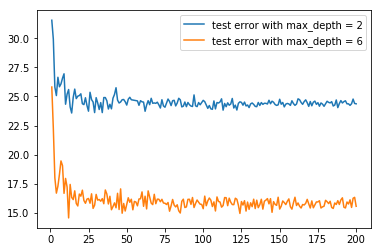

In [7]:
# with max depth: 2, we have to chain n_estimators (number of trees to be aggregagted) from 1:200
ensemble2 = BaggingRegressor(base_estimator = DecisionTreeRegressor(max_depth = 2)) 
ensemble2_params = {'n_estimators': range(1, 201)}
ensemble2_cv = GridSearch(ensemble2, ensemble2_params)
ensemble2_cv.fit(X, y)
ensemble2_cv_results = pd.DataFrame(ensemble2_cv.cv_results_) #estimation results transformed to a pd.dataframe

# with max depth: 6, we have to chain n_estimators (number of trees to be aggregagted) from 1:200
ensemble6 = BaggingRegressor(base_estimator = DecisionTreeRegressor(max_depth = 6)) 
ensemble6_params = {'n_estimators': range(1, 201)}
ensemble6_cv = GridSearch(ensemble6, ensemble6_params)
ensemble6_cv.fit(X, y)
ensemble6_cv_results = pd.DataFrame(ensemble6_cv.cv_results_) #estimation results transformed to a pd.dataframe

# plot
plt.plot(ensemble2_cv_results['param_n_estimators'], -ensemble2_cv_results['mean_test_score'], label='test error with max_depth = 2')
plt.plot(ensemble6_cv_results['param_n_estimators'], -ensemble6_cv_results['mean_test_score'], label='test error with max_depth = 6')
plt.legend()
plt.show()


##### B

In [8]:
#syntax for a random forest is similar to that for a single tree above
rf = RandomForestRegressor(max_features='sqrt', random_state=0) #max_features='sqrt' indicates randomly choosing sqrt(p) of p features at each split
tree_depths = [2, 6]
rf_params = {'n_estimators': range(1, 201), 'max_depth': tree_depths} #n_estimators is number of trees (= boostrap samples)
rf_cv = GridSearch(rf, rf_params)
rf_cv.fit(X, y)
rf_cv_results = pd.DataFrame(rf_cv.cv_results_)
for depth in tree_depths:
    results = rf_cv_results[rf_cv_results['param_max_depth']==depth]
    plt.plot(results['param_n_estimators'], -results['mean_test_score'],
             label='max_depth=%s' % depth)
plt.legend()
plt.show()

##### C

In [9]:
xgb2 = xgb.XGBRegressor(max_depth = 2) 
xgb2_params = {'n_estimators': range(1, 201)}
xgb2_cv = GridSearch(xgb2, xgb2_params)
xgb2_cv.fit(X, y)
xgb2_cv_results = pd.DataFrame(xgb2_cv.cv_results_) #estimation results transformed to a pd.dataframe

xgb6 = xgb.XGBRegressor(max_depth = 6) 
xgb6_params = {'n_estimators': range(1, 201)}
xgb6_cv = GridSearch(xgb6, xgb6_params)
xgb6_cv.fit(X, y)
xgb6_cv_results = pd.DataFrame(xgb6_cv.cv_results_) #estimation results transformed to a pd.dataframe


# plot
plt.plot(xgb2_cv_results['param_n_estimators'], -xgb2_cv_results['mean_test_score'], label='test error with max_depth = 2')
plt.plot(xgb6_cv_results['param_n_estimators'], -xgb6_cv_results['mean_test_score'], label='test error with max_depth = 6')
plt.legend()
plt.show()